In [1]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_classification 
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import brute

In [2]:
df = pd.read_csv("../processed/scout/average_utils/averages.csv")
print(df.dtypes)
#df = df[df["job_input"] == 'pagerank']
print(pd.unique(df["job_input"]))

avgcpu           float64
job_input         object
engine_type       object
data_size         object
node_count         int64
instance_type     object
elapsed_time     float64
name              object
dtype: object
['join' 'kmeans' 'lr' 'naive-bayes' 'pagerank' 'regression' 'terasort'
 'wordcount']


In [88]:
def model(label,test_size, measure,cv,job):
    df = pd.read_csv("../processed/scout/average_utils/averages.csv")
    df = df[df["job_input"] == job]
    # label
    y = df.pop(label)
    #df.drop(columns=['avgcpu','elapsed_time'], inplace=True, errors='ignore')
    # feature vector
    name = df.pop("name")

    X = df
    unencoded_X=X.copy()
    # get columns containing text, apply label encoder and transform text to numbers
    cat_cols = X.select_dtypes(include='object').columns
    d = defaultdict(preprocessing.LabelEncoder)
    X[cat_cols] = X[cat_cols].apply(lambda x: d[x.name].fit_transform(x.astype(str)))

    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=0)

    # set regression model parameters to tweak later and see how results change
    if not cv:
        param_grid = {
        "subsample": [0.8],
        "n_estimators": [250],
        "max_depth": [10],
        "min_samples_split": [4],
        "loss": ["absolute_error"]
        }
    if cv:
        param_grid = {
        "subsample": [0.8],
        "learning_rate": [0.05,0.2],
        "n_estimators": [500,1000],
        "max_depth": [10],
        "min_samples_split": [4],
        "loss": ["absolute_error"]
        }

    clf =  GradientBoostingRegressor()
    reg = GridSearchCV(clf, param_grid, cv=2)
    reg.fit(X_train, y_train)
    optimised_gbr = reg.best_estimator_
    #print(reg.best_params_)
    # attempt to make df of resultant data
    y_pred = reg.predict(X)
    results_features=pd.DataFrame(data={"true":y,"predicted":y_pred,"name":name})
    for col in unencoded_X.columns:
        if col in cat_cols:
            results_features[col] = (d[col].inverse_transform(X[col]))
        else:
            results_features[col]=X[col]
    dfpath = Path(f"../processed/gradboosttest_time_full.csv")
    results_features.to_csv(dfpath, index=False)
    if measure == 'mse':
        metric = mean_squared_error(y_test, reg.predict(X_test))
    #print(f'MSE = {round(mse,2)}')
    if measure == 'r2':
        metric = r2_score(y_test, reg.predict(X_test))
    #print(f'R^2 = {round(r2,3)}')
    if measure == 'mape':
        metric = mean_absolute_percentage_error(y_test, reg.predict(X_test))
    return metric
    '''
    # generate plots 
    test_score = np.zeros((reg.best_params_["n_estimators"],), dtype=np.float64)

    for i, y_pred in enumerate(optimised_gbr.staged_predict(X_test)):
        test_score[i] = mean_squared_error(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
    np.arange(reg.best_params_["n_estimators"]) + 1,
    optimised_gbr.train_score_,
    "b-",
    label="Training Set Deviance",
    )
    plt.plot(
    np.arange(reg.best_params_["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()

    feature_importance = optimised_gbr.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(df.columns)[sorted_idx])
    plt.title("Feature Importance (MDI)")

    result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df.columns)[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()
    '''

In [87]:
def run_model(label,measure,cv,n_iter):
    xs = [120,100,80,60,40,20]
    final_output=[]
    jobs = ['join', 'kmeans', 'lr', 'naive-bayes', 'pagerank', 'regression', 'terasort','wordcount']
    for j in jobs:
        output_job=[]
        for i in range(n_iter):
            iter_output=[]
            for x in xs:
                score = model(label=label,test_size=x, measure = measure, cv=cv,job=j)
                iter_output.append(score)
            output_job.append(iter_output)
        final_output.append(output_job)
    averages = []
    for job_output in final_output:
        job_average=[]
        for values in zip(*job_output):
            avg = sum(values) / len(values)
            job_average.append(avg)
        averages.append(job_average)
    print(averages)
    return averages



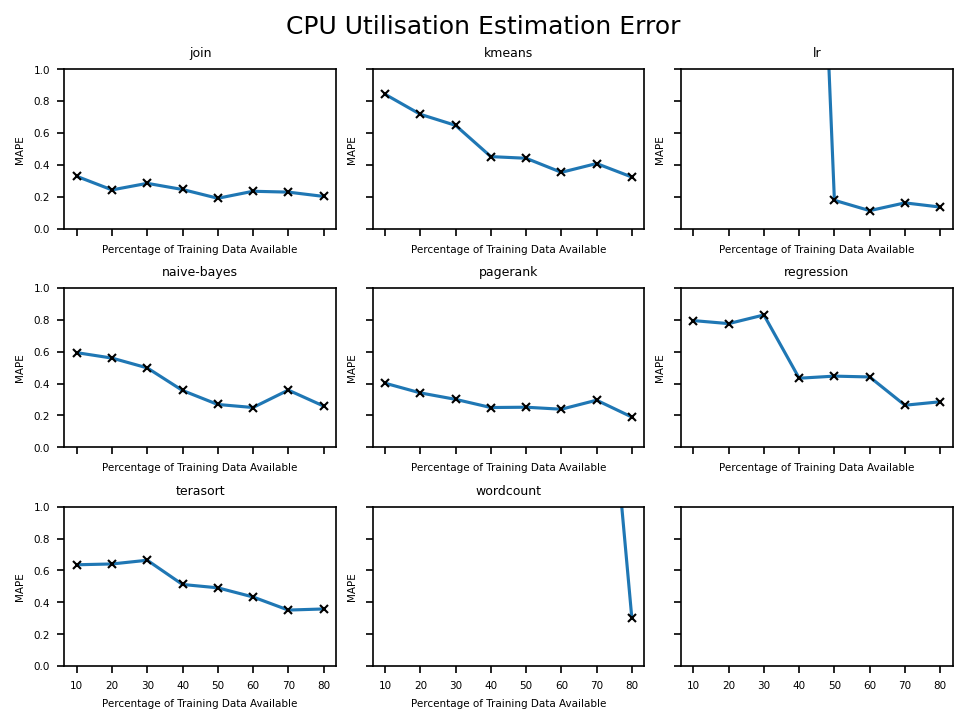

In [49]:
plot_results_subplots(test,title='CPU Utilisation Estimation Error', ylabel='MAPE')

In [56]:
test = run_model(label='avgcpu', measure = 'mape', cv=False, n_iter=1)


{'subsample': [0.8], 'n_estimators': [250], 'max_depth': [10], 'min_samples_split': [4], 'loss': ['absolute_error']}
{'subsample': [0.8], 'n_estimators': [250], 'max_depth': [10], 'min_samples_split': [4], 'loss': ['absolute_error']}


KeyboardInterrupt: 

In [107]:
#jobs = ['join' 'kmeans' 'lr' 'naive-bayes' 'pagerank' 'regression' 'terasort'
 'wordcount']
nocv_cpu_r2 = run_model(label='avgcpu', measure = 'r2', cv=False, n_iter=10)
nocv_cpu_r2 = run_model(label='avgcpu', measure = 'r2', cv=False, n_iter=10)

[36.42349059022174, 44.46761087490522, 42.54353001474037, 42.86598546528712, 50.43029755795284, 50.17379850467767, 70.62425376691847, 94.55767329577485, 147.0410953244065]
[26.061656190904376, 16.211109727815035, 10.556204190261361, 9.112222407278892, 10.48884633570025, 6.471710302360836, 6.5203046451708015, 17.636171809555258, 66.63254720138089]


In [96]:
nocv_cpu_r2 = run_model(label='avgcpu', measure = 'r2', cv=False, n_iter=1)

[[0.8453000219456399, 0.8448807051563247, 0.8272618326311628, 0.8245772968070793, 0.7982237810327526, 0.7875406526710174, 0.7191815346967965, 0.6604668483966739, 0.5021335985593167]]
[[0.7146983458435874, 0.847255375108053, 0.879937074946773, 0.9412337217971718, 0.9391242444189729, 0.9584586549898539, 0.9594025898659223, 0.8936133448201067, 0.6920934144826008]]
[[0.566583510000195, 0.7120789972081814, 0.6886493902723307, 0.680443128340786, 0.6517982348181381, 0.6003812595537413, 0.6036474158760035, -0.050254773473803915, -0.5437523482263971]]
[[0.9689152475305375, 0.8987848232210973, 0.869658122337146, 0.821742710502795, 0.8313091045569085, 0.8134538738312795, 0.7936025081172823, 0.7983018737940726, 0.44883553424866596]]
[[0.8981317980473874, 0.908623473350648, 0.9111229925993409, 0.8963746394411618, 0.8604759157534941, 0.8422265173373602, 0.8364674934224685, 0.8064565700979233, 0.5427345386185207]]
[[0.8891545395311643, 0.9050191166588926, 0.8625795235143169, 0.8829485586976884, 0.771

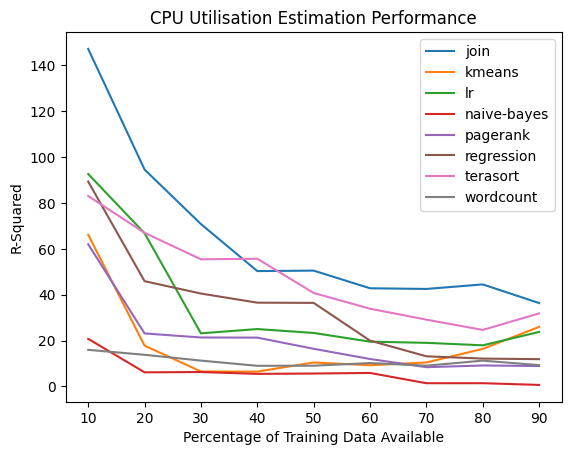

In [99]:
# r2
print("r2")
nocv_cpu_r2 = run_model(label='avgcpu', measure = 'r2', cv=False, n_iter=10)
nocv_time_r2 = run_model(label='elapsed_time', measure = 'r2', cv=False, n_iter=10)
#cv_cpu_r2 = run_model(label='avgcpu', measure = 'r2', cv=True, n_iter=2)
#cv_time_r2 = run_model(label='elapsed_time', measure = 'r2', cv=True, n_iter=2)
#mse
print("mse")
nocv_cpu_mse = run_model(label='avgcpu', measure = 'mse', cv=False, n_iter=10)
#cv_cpu_mse= run_model(label='avgcpu', measure = 'mse', cv=True, n_iter=2)
#cv_time_mse= run_model(label='elapsed_time', measure = 'mse', cv=True, n_iter=2)
nocv_time_mse=run_model(label='elapsed_time', measure = 'mse', cv=False, n_iter=10)
#mape
print("mape")
nocv_cpu_mape = run_model(label='avgcpu', measure = 'mape', cv=False, n_iter=10)
#cv_cpu_mape= run_model(label='avgcpu', measure = 'mape', cv=True, n_iter=2)
#cv_time_mape= run_model(label='elapsed_time', measure = 'mape', cv=True, n_iter=2)
nocv_time_mape=run_model(label='elapsed_time', measure = 'mape', cv=False, n_iter=10)


#cv_cpu_r2 = run_model(label='avgcpu', measure = 'r2', cv=True, n_iter=2)
#cv_time_r2 = run_model(label='elapsed_time', measure = 'r2', cv=True, n_iter=2)
#cv_cpu_mse= run_model(label='avgcpu', measure = 'mse', cv=True, n_iter=2)
#cv_time_mse= run_model(label='elapsed_time', measure = 'mse', cv=True, n_iter=2)
#cv_cpu_mape= run_model(label='avgcpu', measure = 'mape', cv=True, n_iter=2)
#cv_time_mape= run_model(label='elapsed_time', measure = 'mape', cv=True, n_iter=2)


r2
[[0.6258529141578894, 0.6924214450428067, 0.7503689450792945, 0.8329525742163035, 0.8899970849852039, 0.8947632535175923], [0.6892352432912989, 0.9266461303105069, 0.9424438545514022, 0.9212449836470082, 0.9370855132041941, 0.9199394350631277], [-0.0880573720946863, 0.485596058165079, 0.6144228446392965, 0.618268092116599, 0.7581328516409199, 0.7204746169565721], [0.5155673350256007, 0.8169480881870698, 0.8273174792308641, 0.8400647970384032, 0.8280491777817979, 0.8621610853805614], [0.9064577560175187, 0.9082362312087181, 0.8996898515045861, 0.9110086667038916, 0.9101911459445331, 0.8250294538639376], [0.6916661684637874, 0.7581963363277651, 0.7838768192444701, 0.8386925171948523, 0.8691474498324231, 0.9072430351843523], [0.30275931295314845, 0.3665469844100842, 0.4357969626957036, 0.23847317846866467, 0.4543588292025523, 0.5617380429937275], [0.7724141206030138, 0.7754497571941616, 0.7770705064904472, 0.7904006557504867, 0.8149425465982704, 0.8633197142592056]]
[[0.464635120263509

In [113]:
#plot_results_subplots(nocv_time_r2,title='Elapsed Time Estimation Performance', ylabel='R-Sqaured Coefficient')
#cv_cpu_mape= run_model(label='avgcpu', measure = 'mape', cv=True, n_iter=1)
cv_time_mape= run_model(label='elapsed_time', measure = 'mape', cv=True, n_iter=1)

[[0.2824532352552661, 0.25407935442186813, 0.30237520829642117, 0.17933145875675707, 0.25080770064904684, 0.17870534786480313], [0.9728786504564149, 0.7380737885761439, 0.5952543960611285, 0.43213579493966847, 0.35519842099426685, 0.3074342868274408], [2.4621006331762247, 4.150291885450229, 5.13101555957235, 0.1910493124918542, 0.15230664209844677, 0.11700390422264861], [0.7163257060114459, 0.6445862231688524, 0.37066366884252056, 0.4277489190956209, 0.2635965309624121, 0.23333044050931706], [0.24097375254432013, 0.26195511884794376, 0.3174453953859798, 0.26901323415585027, 0.20144120995299075, 0.23877250267395983], [1.7265859163083483, 1.071801013659154, 0.808940741921138, 0.44696055113021893, 0.30790303524589807, 0.26488378176675353], [0.7964119798385414, 0.5396421091415717, 0.6880418539699109, 0.5420983340774677, 0.3371263219023601, 0.32490847428210057], [1.7040859719178942, 1.1970315869155093, 1.38016919592458, 1.5166498664239803, 1.683323422781055, 3.471109765116919]]


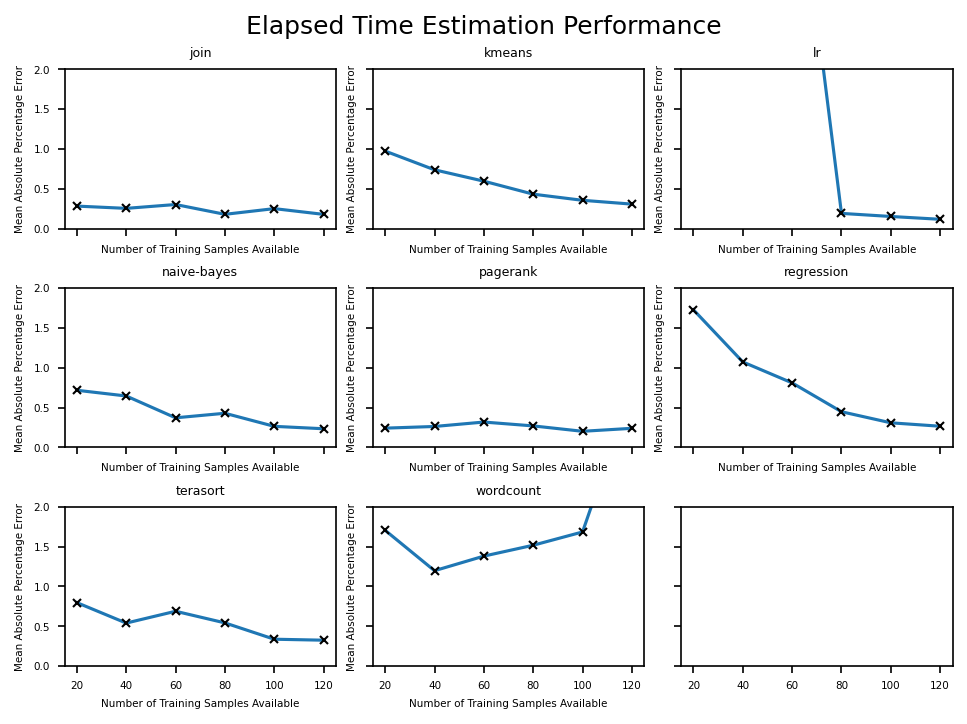

In [119]:
plot_results_subplots(cv_time_mape,title='Elapsed Time Estimation Performance', ylabel='Mean Absolute Percentage Error')

In [11]:
#CV metrics
cv_cpu_r2 = run_model(label='avgcpu', measure = 'r2', cv=True, n_iter=2)
cv_time_r2 = run_model(label='elapsed_time', measure = 'r2', cv=True, n_iter=2)
cv_cpu_mse= run_model(label='avgcpu', measure = 'mse', cv=True, n_iter=2)
cv_time_mse= run_model(label='elapsed_time', measure = 'mse', cv=True, n_iter=2)
cv_cpu_mape= run_model(label='avgcpu', measure = 'mape', cv=True, n_iter=2)
cv_time_mape= run_model(label='elapsed_time', measure = 'mape', cv=True, n_iter=2)

[0.8980079474921292, 0.889281420363685, 0.8694492833466776, 0.7976349752855789, 0.794086596223103, 0.7606525519215566, 0.7142516276802553, 0.6464847555655704, 0.5497514124970806]
[0.7119394913224999, 0.867231145840343, 0.9290341951908414, 0.9441421275809001, 0.9376580235213441, 0.9560028532476411, 0.9532006529004484, 0.8871630801331749, 0.678436229895325]
[0.5486931622120724, 0.7663683947520404, 0.5563326405553033, 0.5828631565432998, 0.6105899735784402, 0.5852510849853498, 0.46517633733312863, -0.5283514554281168, -0.4038579986248313]
[0.9590774725392834, 0.8067940177489709, 0.8346550545545972, 0.8396435442892138, 0.8195852345400645, 0.8012722666624257, 0.8096559258851944, 0.8209957005760165, 0.41308945360795796]
[0.8688453074464373, 0.8906866161045668, 0.8827945870962562, 0.8590964853995962, 0.8719161550755667, 0.8401296380813974, 0.8306615518873466, 0.7618978075610421, 0.5431841193502127]
[0.8891766781342565, 0.8712471147814607, 0.81630286925781, 0.8568664811517699, 0.76435071705753

In [115]:
for x in cv_time_mape:
    print([(round(i*100,2)) for i in x])

[28.25, 25.41, 30.24, 17.93, 25.08, 17.87]
[97.29, 73.81, 59.53, 43.21, 35.52, 30.74]
[246.21, 415.03, 513.1, 19.1, 15.23, 11.7]
[71.63, 64.46, 37.07, 42.77, 26.36, 23.33]
[24.1, 26.2, 31.74, 26.9, 20.14, 23.88]
[172.66, 107.18, 80.89, 44.7, 30.79, 26.49]
[79.64, 53.96, 68.8, 54.21, 33.71, 32.49]
[170.41, 119.7, 138.02, 151.66, 168.33, 347.11]


In [120]:
for x in nocv_time_mape:
    print([(round(i*100,2)) for i in x])

[28.94, 26.59, 27.72, 19.54, 22.94, 18.79]
[106.91, 75.33, 61.67, 46.33, 31.66, 31.21]
[269.26, 397.05, 513.68, 17.57, 15.54, 12.42]
[72.68, 54.72, 41.71, 34.34, 29.58, 26.29]
[24.94, 27.33, 30.6, 27.52, 19.75, 20.24]
[139.53, 84.5, 75.96, 42.32, 26.79, 24.64]
[77.86, 61.81, 63.31, 47.46, 37.2, 30.43]
[171.03, 125.02, 137.28, 154.28, 187.81, 349.98]


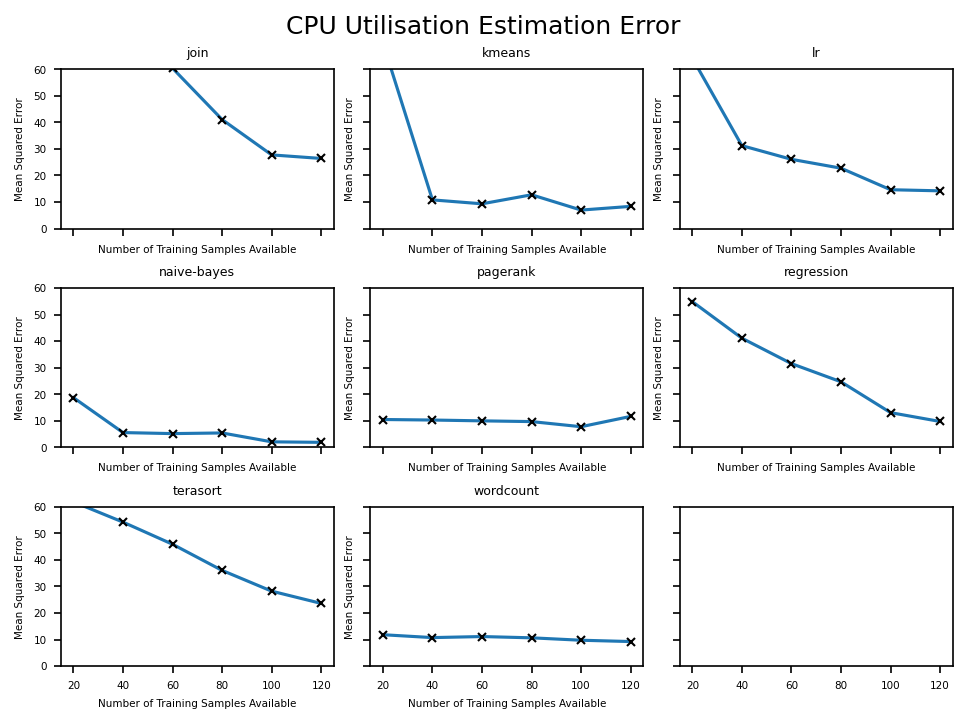

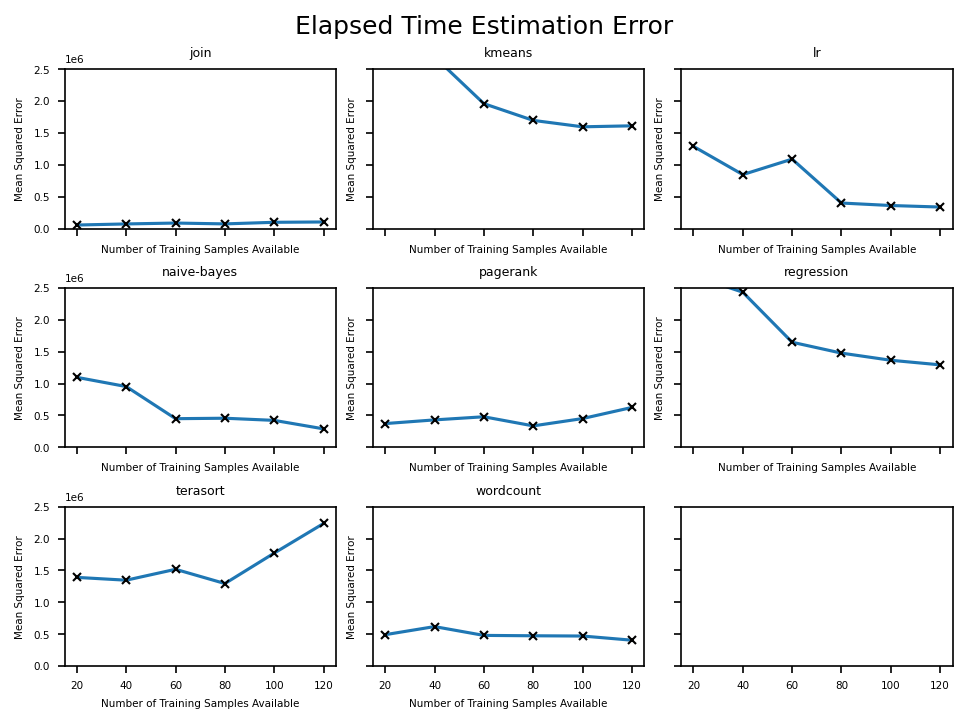

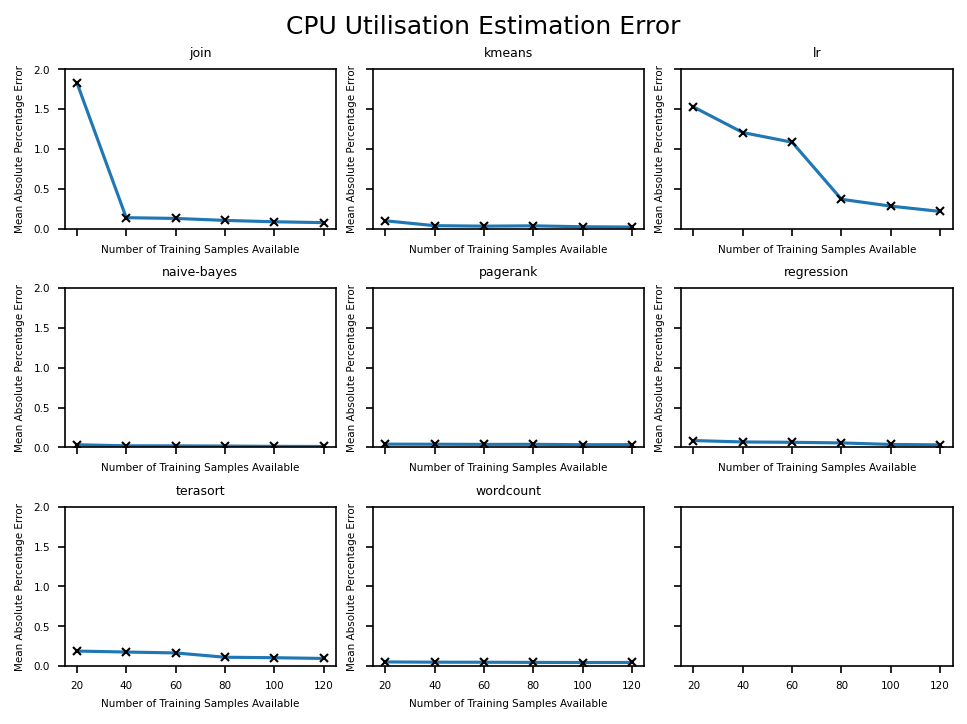

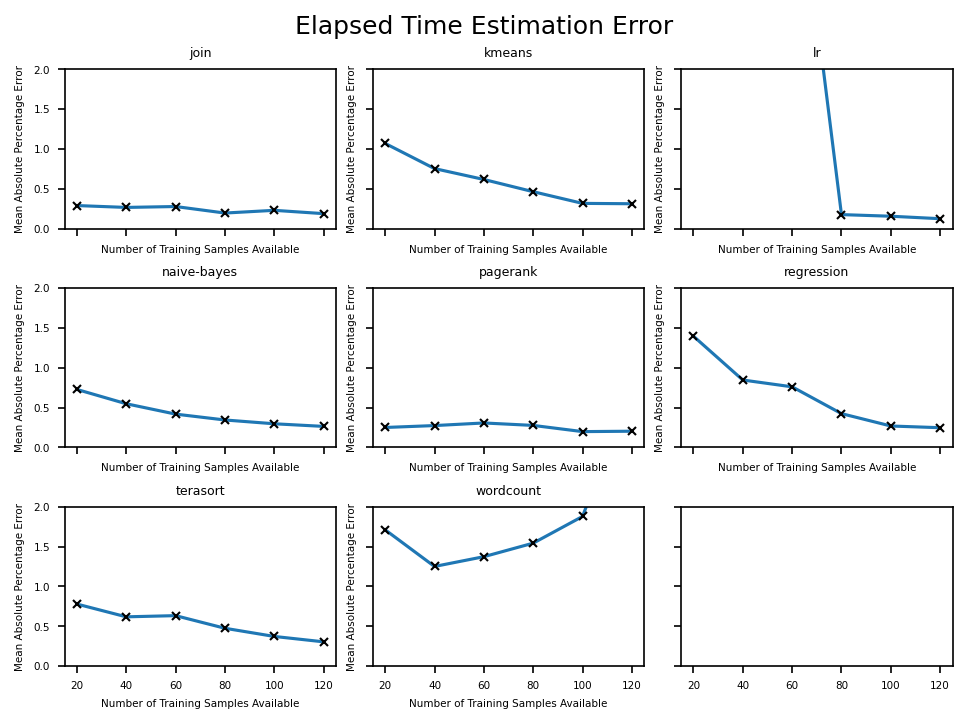

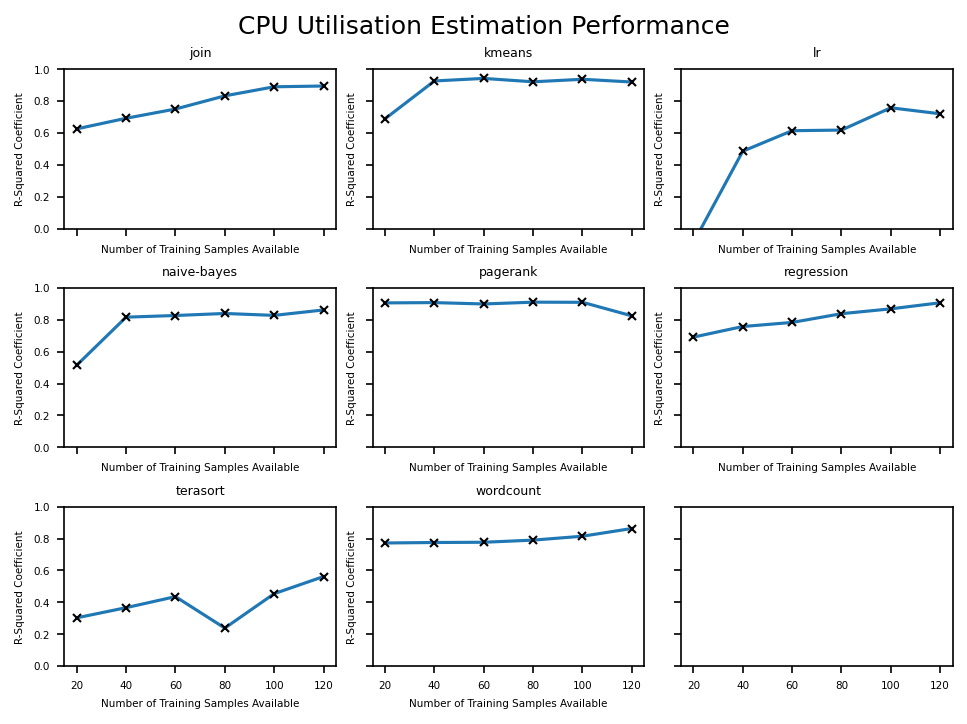

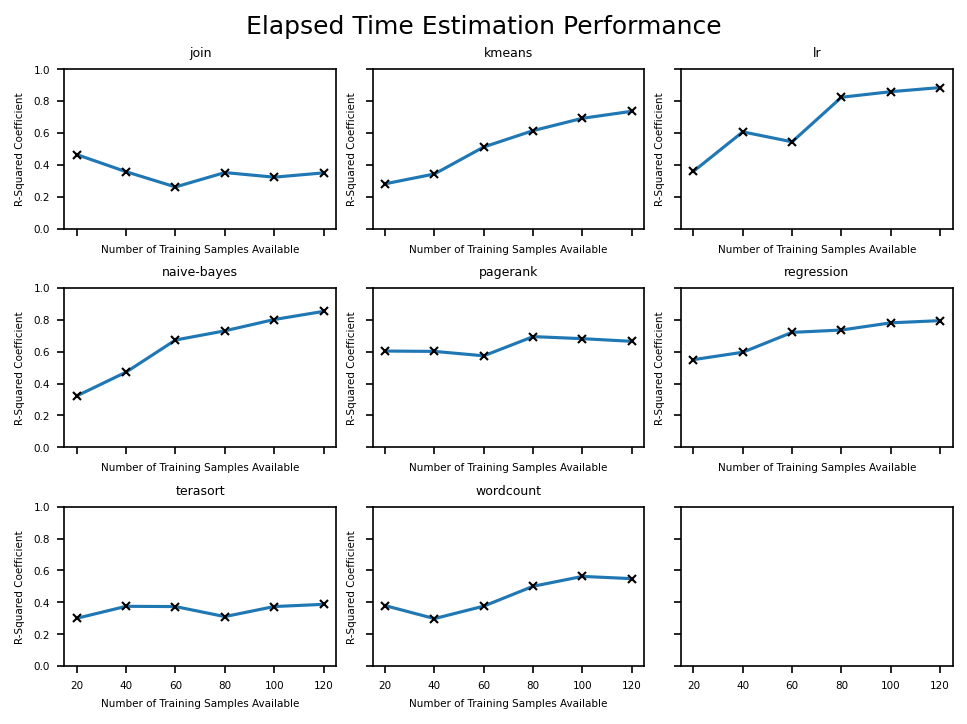

In [104]:
plot_results_subplots(nocv_cpu_mse,title='CPU Utilisation Estimation Error', ylabel='Mean Squared Error')
plot_results_subplots(nocv_time_mse,title='Elapsed Time Estimation Error', ylabel='Mean Squared Error')
plot_results_subplots(nocv_cpu_mape,title='CPU Utilisation Estimation Error', ylabel='Mean Absolute Percentage Error')
plot_results_subplots(nocv_time_mape,title='Elapsed Time Estimation Error', ylabel='Mean Absolute Percentage Error')
plot_results_subplots(nocv_cpu_r2,title='CPU Utilisation Estimation Performance', ylabel='R-Squared Coefficient')
plot_results_subplots(nocv_time_r2,title='Elapsed Time Estimation Performance', ylabel='R-Squared Coefficient')

In [118]:
#mape
nocv_cpu_mape = run_model(label='avgcpu', measure = 'mape', cv=False, n_iter=10)
#cv_cpu_mape= run_model(label='avgcpu', measure = 'mape', cv=True, n_iter=2)
#cv_time_mape= run_model(label='elapsed_time', measure = 'mape', cv=True, n_iter=2)
nocv_time_mape=run_model(label='elapsed_time', measure = 'mape', cv=False, n_iter=10)

[0.07171247713922482, 0.1050620288684438, 0.09899716498980843, 0.10718899871527275, 0.11694940856717798, 0.11784358764399083, 0.13359995141170783, 1.6531971442995976, 1.6520974622129656]
[0.03706661888565768, 0.031110809864733812, 0.025212125237213702, 0.026341374105623174, 0.028171814512681945, 0.0265511736469973, 0.02652789096826759, 0.04288708039653991, 0.09342041107025567]
[0.29425524689192617, 0.3812023010242934, 0.34872556548903655, 0.3522151872934601, 1.088546350004645, 1.0752372077012966, 1.0743114868728074, 1.5304174787785603, 1.640029832844916]
[0.007556207842903716, 0.01026195676569442, 0.010505056257450811, 0.017029707372830973, 0.017778891668099157, 0.017324942718082378, 0.021053878871303264, 0.021156445306983816, 0.03645439317558588]
[0.03633586152239926, 0.03737316884255912, 0.034319559970891346, 0.04130297068599374, 0.048898232884607484, 0.05569602302488517, 0.05849006615105668, 0.059963626231456096, 0.10415047059297114]
[0.03780807826185354, 0.038809883109244867, 0.038

In [89]:
nocv_cpu_mape=run_model(label='avgcpu', measure = 'mape', cv=False, n_iter=1)

[[1.8466095180879532, 0.14110079379583537, 0.12212008098216383, 0.10096104259793309, 0.08585190543248518, 0.06305861824766254], [0.09361827139194484, 0.03515531012824961, 0.033806607954703506, 0.03359016096425607, 0.01983944789132857, 0.02038297818074514], [1.5922279245407367, 1.0751217117162992, 0.9844010153862606, 0.37059421125788816, 0.2854570506423657, 0.19176952312458112], [0.03148384872860204, 0.019764916565425148, 0.01841802830432463, 0.015733548537534656, 0.010746310789734401, 0.011710790320329578], [0.04050763550666994, 0.03815900215253529, 0.034974128788159996, 0.04120507148726614, 0.032275430055373984, 0.02677476068184818], [0.08583066957018118, 0.06634910697257845, 0.05794301822085766, 0.05855866352512555, 0.030790916232165122, 0.03133883103050007], [0.19264687886749052, 0.16726383821454344, 0.15645623658768915, 0.10996982683299733, 0.10485166533584538, 0.10477075924624138], [0.05276418450060881, 0.048812896644541165, 0.04789619028172143, 0.04391269391887316, 0.044917508422

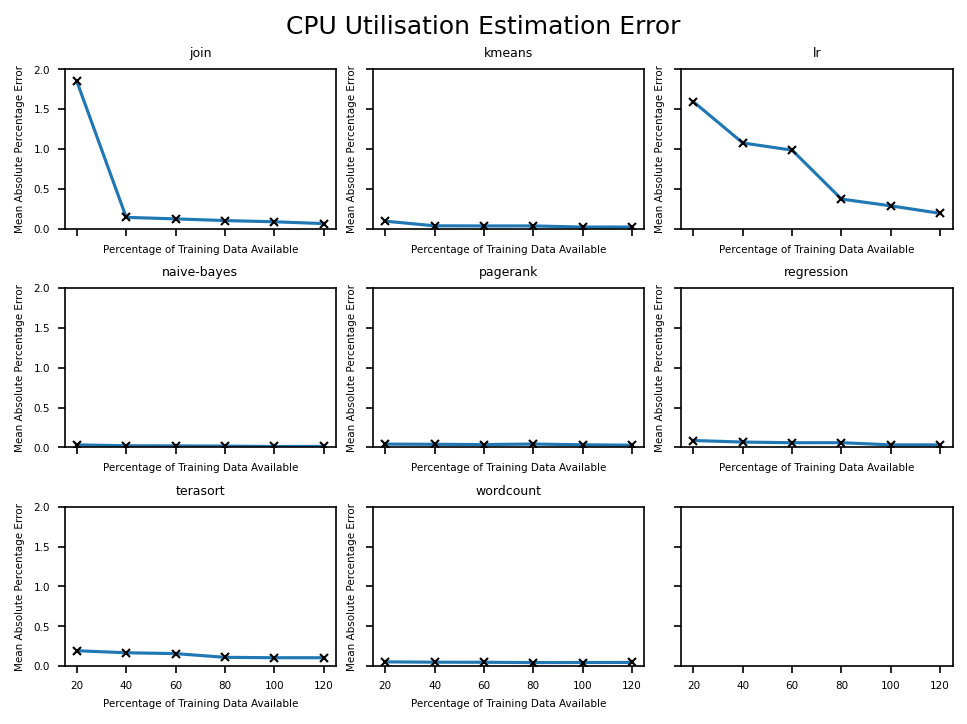

In [98]:
plot_results_subplots(nocv_cpu_mape,title='CPU Utilisation Estimation Error', ylabel='Mean Absolute Percentage Error')


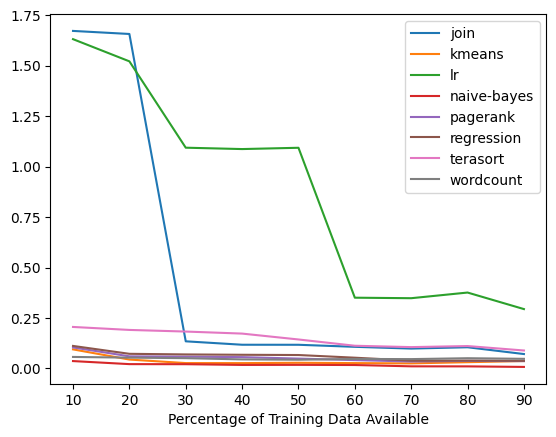

In [103]:
def plot_results_subplots(data,title,ylabel):
    jobs = ['join', 'kmeans', 'lr', 'naive-bayes', 'pagerank', 'regression', 'terasort','wordcount']
    xs = [20,40,60,80,100,120]
    fig, axs = plt.subplots(3,3,sharex=True, sharey=True)
    ax=axs.flat
    fig.set_dpi(150)
    plt.rcParams.update({'font.size': 10})
    plt.suptitle(title)
    plt.rcParams.update({'font.size': 5})
    if 'R-Squared' in ylabel:
        ylim=1
    elif 'Absolute' in ylabel:
        ylim=2
    elif 'Time' in title:
        ylim=2500000
    else:
        ylim=60
    for ind,val in enumerate(jobs):
        ax[ind].plot(xs,data[ind], label=val, marker='x',markersize=4,mfc='black',mec='black')
        ax[ind].set_title(val)
        ax[ind].set_xlabel("Number of Training Samples Available")
        ax[ind].set_ylabel(ylabel)
        ax[ind].set_xticks(xs)
        ax[ind].set_ylim([0,ylim])
    plt.tight_layout()
    #for ind,val in enumerate(jobs):
    #    plt.plot(xs,data[ind], label=val)
    #plt.xlabel("Percentage of Training Data Available")
    #plt.legend()
'''
plot_results_subplots(nocv_cpu_mse,title='CPU Utilisation Estimation Error', ylabel='Mean Squared Error')
plot_results_subplots(nocv_time_mse,title='Elapsed Time Estimation Error', ylabel='Mean Squared Error')
plot_results_subplots(nocv_cpu_mape,title='CPU Utilisation Estimation Error', ylabel='Mean Absolute Percentage Error')
plot_results_subplots(nocv_time_mape,title='Elapsed Time Estimation Error', ylabel='Mean Absolute Percentage Error')
plot_results_subplots(nocv_cpu_r2,title='CPU Utilisation Estimation Performance', ylabel='R-Squared Coefficient')
plot_results_subplots(nocv_time_r2,title='Elapsed Time Estimation Performance', ylabel='R-Sqaured Coefficient')
'''
#plot_results_subplots(nocv_time_mape,title='CPU Utilisation Estimation Error', ylabel='Mean Squared Error')

"\nplot_results_subplots(nocv_cpu_mse,title='CPU Utilisation Estimation Error', ylabel='Mean Squared Error')\nplot_results_subplots(nocv_time_mse,title='Elapsed Time Estimation Error', ylabel='Mean Squared Error')\nplot_results_subplots(nocv_cpu_mape,title='CPU Utilisation Estimation Error', ylabel='Mean Absolute Percentage Error')\nplot_results_subplots(nocv_time_mape,title='Elapsed Time Estimation Error', ylabel='Mean Absolute Percentage Error')\nplot_results_subplots(nocv_cpu_r2,title='CPU Utilisation Estimation Performance', ylabel='R-Squared Coefficient')\nplot_results_subplots(nocv_time_r2,title='Elapsed Time Estimation Performance', ylabel='R-Sqaured Coefficient')\n"

ValueError: x and y must have same first dimension, but have shapes (9,) and (8, 9)

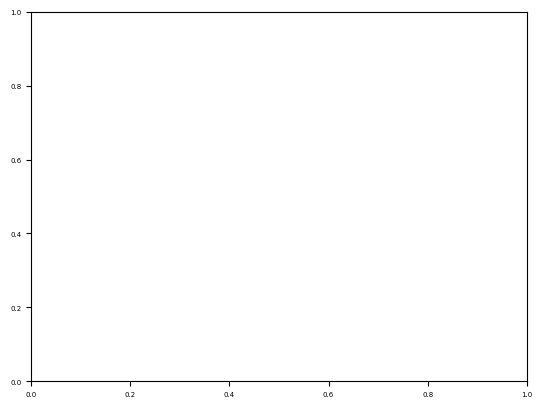

In [40]:
xs = [x*10 for x in range(9, 0, -1)]
xs
plt.plot(xs,nocv_time_mse, label='no CV')
plt.plot(xs, cv_time_mse, label = 'CV')
plt.xlabel("Percentage of Training Data Available")
plt.ylabel("Mean Squared Error")
plt.title("Elapsed Time Estimation Error")
plt.legend()

In [110]:
nocv_time_mse

[[199176.8776096954,
  102385.79938734628,
  121516.27886083865,
  90416.83725293523,
  103754.97078777137,
  122080.18764087111,
  63052.35169399241,
  59245.8580010809,
  73109.5968749701],
 [1690334.4516615365,
  1919033.4629016921,
  2015873.1563071278,
  2073522.609029685,
  1950104.3524904035,
  3159778.9453495634,
  3170069.4367933148,
  3347067.639648767,
  3219111.766708526],
 [152214.68701524235,
  499223.53763186384,
  496304.4497331799,
  623166.840293724,
  775052.0532601868,
  1069823.1631954904,
  1342399.7699796786,
  2006353.406278416,
  2276984.733951257],
 [317430.26574838546,
  197089.747966602,
  337891.19529696007,
  360430.45863108046,
  444925.0415984496,
  744799.96094766,
  811527.5648803378,
  1047285.2582414716,
  1087084.6109785696],
 [481192.5706844546,
  345205.4314620536,
  470876.30842725636,
  426033.2438873622,
  426482.9861659942,
  424216.453976089,
  467117.122205652,
  515288.68657070195,
  631514.5868058066],
 [1432144.819384524,
  909339.2990990

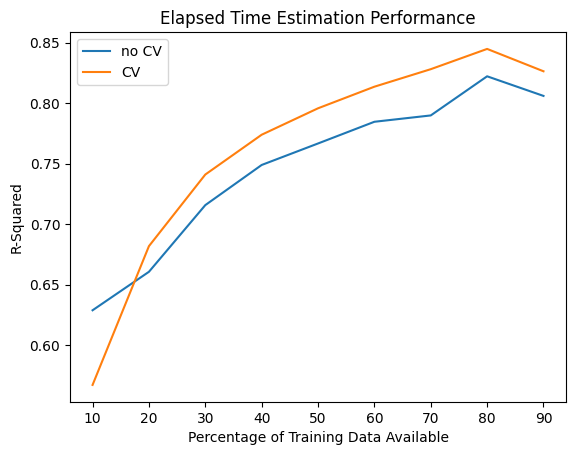

In [32]:
plt.plot(xs,nocv_time_r2, label='no CV')
plt.plot(xs, cv_time_r2, label = 'CV')
plt.xlabel("Percentage of Training Data Available")
plt.ylabel("R-Squared")
plt.title("Elapsed Time Estimation Performance")
plt.legend()

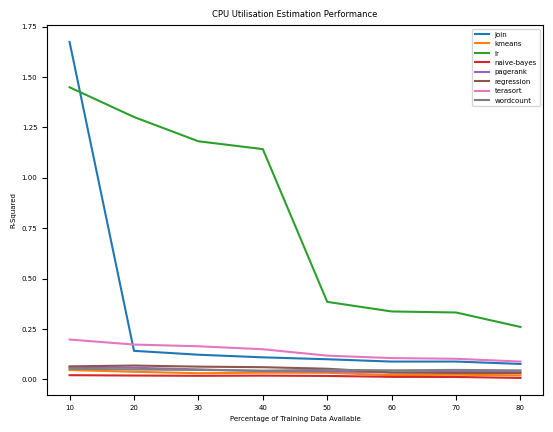

In [61]:
jobs = ['join', 'kmeans', 'lr', 'naive-bayes', 'pagerank', 'regression', 'terasort','wordcount']
xs = [x*10 for x in range(8, 0, -1)]
for ind,val in enumerate(jobs):
    plt.plot(xs,nocv_cpu_mape[ind], label=val)
#plt.plot(xs, cv_cpu_r2, label = 'CV')
plt.xlabel("Percentage of Training Data Available")
plt.ylabel("R-Squared")
plt.title("CPU Utilisation Estimation Performance")
plt.legend()

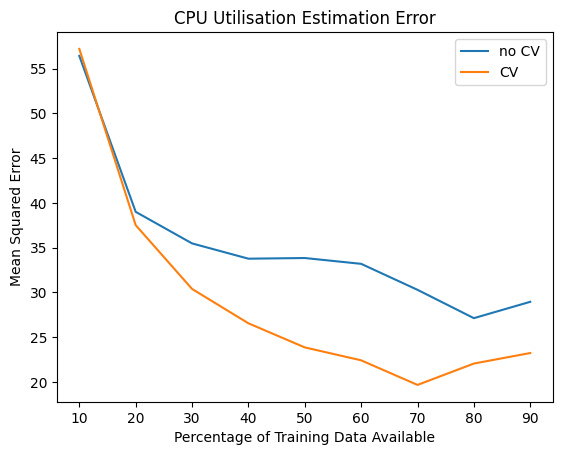

In [33]:
plt.plot(xs,nocv_cpu_mse, label='no CV')
plt.plot(xs, cv_cpu_mse, label = 'CV')
plt.xlabel("Percentage of Training Data Available")
plt.ylabel("Mean Squared Error")
plt.title("CPU Utilisation Estimation Error")
plt.legend()

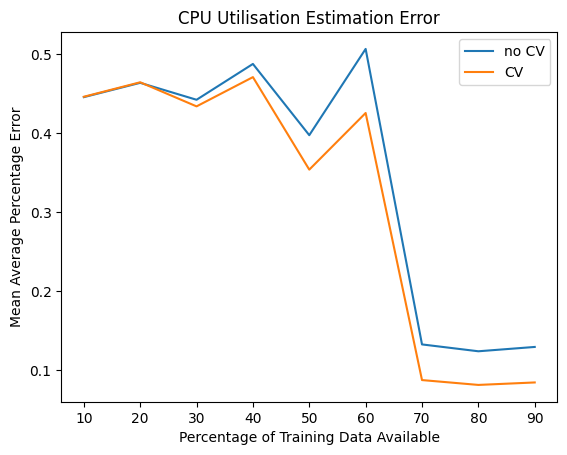

In [38]:
plt.plot(xs,nocv_cpu_mape, label='no CV')
plt.plot(xs, cv_cpu_mape, label = 'CV')
plt.xlabel("Percentage of Training Data Available")
plt.ylabel("Mean Average Percentage Error")
plt.title("CPU Utilisation Estimation Error")
plt.legend()

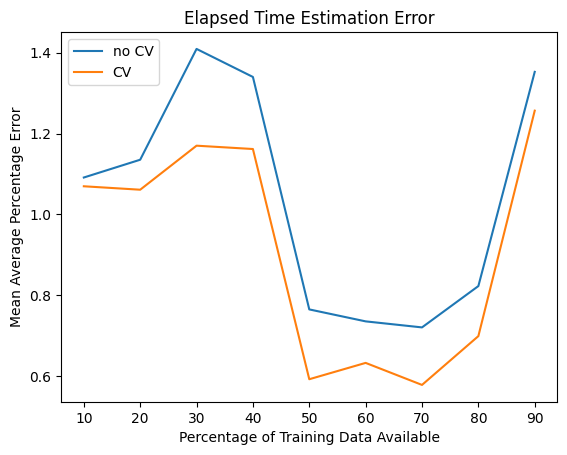

In [37]:
plt.plot(xs,nocv_time_mape, label='no CV')
plt.plot(xs, cv_time_mape, label = 'CV')
plt.xlabel("Percentage of Training Data Available")
plt.ylabel("Mean Average Percentage Error")
plt.title("Elapsed Time Estimation Error")
plt.legend()